# 教師なし

## クラスタリング
- k-means法
- エルボー法によるクラスター数の推定
- k-means法以外の手法

多数のデータをいくつかの類似グループに分類する手法（ターゲットのセグメンテーション）

## 主成分分析
変数が多い場合の次元圧縮の手法

## マーケットバスケット分析

## アソシエーション分析

In [3]:
# データ加工・処理・分析ライブラリ
import numpy as np
import numpy.random as random
import scipy as sp
from pandas import Series, DataFrame
import pandas as pd

# 可視化ライブラリ
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

# 機械学習ライブラリ
import sklearn

# クラスタリング
1. 平面に入力データをプロットする
2. さらにランダムに3つの点をプロットする
3. それぞれのランダムな点を、クラスターの重心点とラベリングする
4. 入力データの各点について、3つの重心点のうち最も近いものを選び、その番号を所属クラスターとする
5. 全ての入力データについてクラスター番号を決め、それぞれのクラスターの重心を計算する
6. それぞれの重心を新しいクラスターの重心とする
7. 4-6を繰り返す

In [4]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

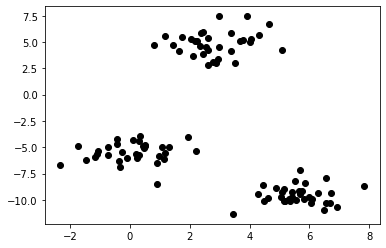

In [5]:
# 注意：make_blobsは2つの値を返すため、一方は使用しない「 _ 」で受け取る
X, _ = make_blobs(random_state=10)
plt.scatter(X[:,0],X[:,1],color='black')

In [6]:
kmeans = KMeans(init='random', n_clusters=3)
kmeans.fit(X)
y_pred = kmeans.predict(X)

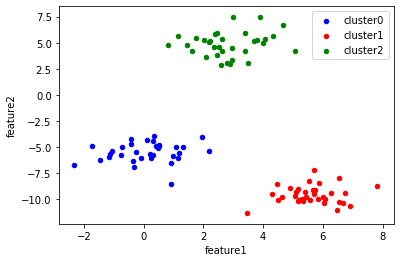

In [7]:
merge_data = pd.concat([pd.DataFrame(X[:,0]), pd.DataFrame(X[:,1]), pd.DataFrame(y_pred)], axis=1)
merge_data.columns = ['feature1','feature2','cluster']
ax = None
colors = ['blue', 'red', 'green']
for i, data in merge_data.groupby('cluster'):
    ax = data.plot.scatter(x='feature1', y='feature2', color=colors[i],
                                           label=f'cluster{i}', ax=ax)

### クラスタリング活用例（金融）
データ分析の現場では目的変数が定まらないということは珍しくなく、分析者自身がデータ理解を深めるための第一歩として教師なし学習（クラスタリング）を採用することがあります。

In [8]:
import requests, zipfile
import io
zip_file_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip'
r = requests.get(zip_file_url, stream=True)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

In [9]:
bank= pd.read_csv('bank-full.csv', sep=';')
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [10]:
print('データ形式(X,y):{}'.format(bank.shape))
print('欠損データの数:{}'.format(bank.isnull().sum().sum()))

データ形式(X,y):(45211, 17)
欠損データの数:0


In [11]:
from sklearn.preprocessing import StandardScaler
bank_sub = bank[['age','balance','campaign','previous']]
sc = StandardScaler()
sc.fit(bank_sub)
bank_sub_std = sc.transform(bank_sub)

In [12]:
bank_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   age       45211 non-null  int64
 1   balance   45211 non-null  int64
 2   campaign  45211 non-null  int64
 3   previous  45211 non-null  int64
dtypes: int64(4)
memory usage: 1.4 MB


### fit, transform, fit_transform
- fit: 渡されたデータの最大値、最小値、平均、標準偏差、傾き...などの統計を取得して、内部メモリに保存する。
- transform: `fit()`で取得した統計情報を使って、渡されたデータを実際に書き換える。
- fit_transform: `fit()`をした後に、同じデータに対して`transform()`を行う。

#### 使い分け
- トレーニングデータの場合は、それ自体の統計を基に正規化や欠損値処理を行っても問題ないので、`fit_transform()`を使って構わない。
- テストデータの場合は、比較的データ数が少なく、トレーニングデータの統計を使って正規化や欠損値処理を行うべきなので、トレーニングデータに対する`fit()`の結果で、`transform()`を行う必要がある。

0    14411
1    23608
2     3837
3     1373
4     1282
5      700
Name: cluster_number, dtype: int64


Text(0, 0.5, 'count')

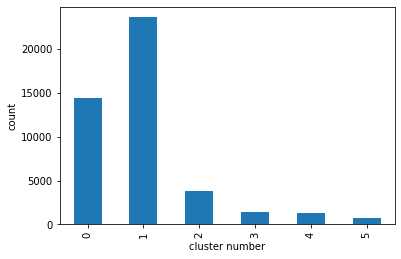

In [13]:
kmeans = KMeans(init='random', n_clusters=6, random_state=0)
kmeans.fit(bank_sub_std)
labels = pd.Series(kmeans.labels_, name='cluster_number')
print(labels.value_counts(sort=False))
ax = labels.value_counts(sort=False).plot(kind='bar')
ax.set_xlabel('cluster number')
ax.set_ylabel('count')

### エルボー法によるクラスター数の推定
エルボー法はクラスターの重心点とクラスター所属の各点の距離の総和に着目します。

クラスター数が1つから適切な数まで増える過程では、各点がより近いクラスター重心に所属できるようになるので、この総和は相応に減少することが期待できます。一方、いったん適切な数を超えて、さらにクラスター数が増える過程では、この総和の減少度合いが低下すると予想されます。このように、クラスター数の増加に伴う重心点と各点の距離の総和の減少度合いの変わり目に着目して、適切なクラスター数を決めようと判断しようとするのがエルボー法です。

距離の総和はKMeansオブジェクトのinertia_属性で取得できます。

Text(0, 0.5, 'Distortion')

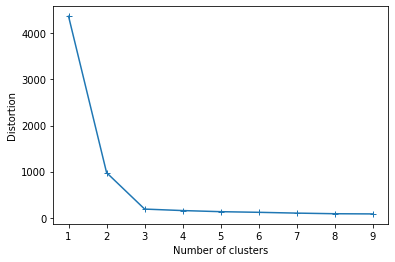

In [14]:
dist_list =[]
for i in range(1,10):
    kmeans= KMeans(n_clusters=i, init='random', random_state=0)
    kmeans.fit(X)
    dist_list.append(kmeans.inertia_)
    
plt.plot(range(1,10), dist_list,marker='+')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')

Text(0, 0.5, 'Distortion')

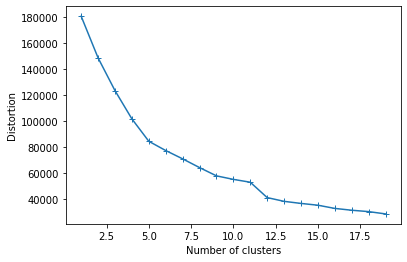

In [15]:
dist_list =[]
for i in range(1,20):
    kmeans= KMeans(n_clusters=i, init='random', random_state=0)
    kmeans.fit(bank_sub_std)
    dist_list.append(kmeans.inertia_)

plt.plot(range(1,20), dist_list,marker='+')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')

もしエルボー法で傾向が見られない場合は、シルエット係数の算出など、その他のクラスター数判断のための方法を試す、分析領域の固有知識に基づき決定する、またはデータの概要把握と割り切り解釈可能な範囲のクラスター数で処理を進めるなどしましょう。

### シルエット分析
- クラスタ内のサンプルがどの程度密にグループされているか（凝集度）の目安となるグラフを可視化（=パッと見でクラスターが上手くできているかなんとなくわかる）
- １つのクラスターが隣接するクラスターとどれくらい離れているかを可視化する

In [17]:
bank_with_cluster = pd.concat([bank, labels], axis=1)
bank_with_cluster.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,cluster_number
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no,1
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no,1


In [19]:
bins = [15,20,25,30,35,40,45,50,55,60,65,100]
qcut_age = pd.cut(bank_with_cluster.age, bins, right=False)
df = pd.concat([bank_with_cluster.cluster_number, qcut_age], axis=1)
cross_cluster_age = df.groupby(['cluster_number', 'age']).size().unstack().fillna(0)
cross_cluster_age

age,"[15, 20)","[20, 25)","[25, 30)","[30, 35)","[35, 40)","[40, 45)","[45, 50)","[50, 55)","[55, 60)","[60, 65)","[65, 100)"
cluster_number,,,,,,,,,,,
0,0,0,0,0,0,1023,4490,3833,3480,850,735
1,45,705,3965,8221,6731,3941,0,0,0,0,0
2,1,20,230,788,956,718,598,328,165,29,4
3,0,20,129,327,306,186,145,117,71,38,34
4,0,11,74,240,219,203,156,140,155,48,36
5,1,6,66,164,137,114,81,70,51,9,1


In [20]:
hist_age = pd.value_counts(qcut_age)
hist_age

[30, 35)     9740
[35, 40)     8349
[40, 45)     6185
[45, 50)     5470
[50, 55)     4488
[25, 30)     4464
[55, 60)     3922
[60, 65)      974
[65, 100)     810
[20, 25)      762
[15, 20)       47
Name: age, dtype: int64

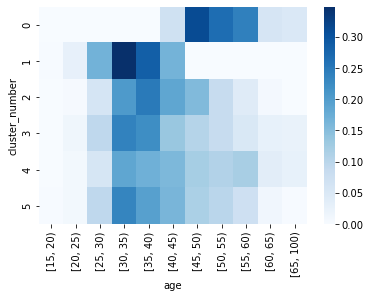

In [21]:
sns.heatmap(cross_cluster_age.apply(lambda x : x/x.sum(), axis=1), cmap='Blues')

## 主成分分析 PCA（Principle Component Analysis）
説明変数と目的変数を一つ一つ見ていては大変。

元データの持つ情報をできるだけ失わずに変数の数を圧縮できるため、探索的分析の前処理や予測モデル構築時の目処理として使われる。

教師あり学習でも使われる。

相関係数0.889:


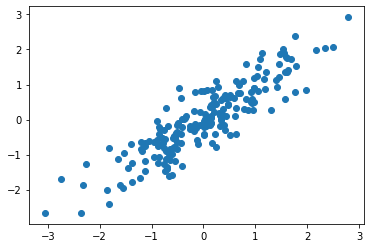

In [22]:
from sklearn.preprocessing import StandardScaler

sample = np.random.RandomState(1)
X = np.dot(sample.rand(2,2), sample.randn(2,200)).T

sc = StandardScaler()
X_std = sc.fit_transform(X)
print('相関係数{:.3f}:'.format(sp.stats.pearsonr(X_std[:, 0], X_std[:, 1])[0]))
plt.scatter(X_std[:, 0], X_std[:, 1])

In [23]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2) # 何次元まで圧縮したいか
pca.fit(X_std)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [24]:
print(pca.components_)

[[-0.70710678 -0.70710678]
 [-0.70710678  0.70710678]]


In [25]:
print('各主成分の分散:{}'.format(pca.explained_variance_))

各主成分の分散:[1.89888438 0.11116588]


In [26]:
print('各主成分の分散割合:{}'.format(pca.explained_variance_ratio_))

各主成分の分散割合:[0.94469498 0.05530502]
